# Baseline Flat Classification

This notebook trains a **flat (non-hierarchical) classifier** on the merged 3D MedMNIST datasets for comparison with the hierarchical approach.

The flat classifier predicts the fine-grained label directly without the intermediate region classification step.

In [1]:
import sys
sys.path.insert(0, '..')

import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import seaborn as sns
from medmnist import INFO
import os

from config import (
    DEVICE, DATA_CONFIG, MODEL_CONFIG, TRAINING_CONFIG,
    PATHS, set_seed, DEFAULT_MERGED_DATASETS
)

from utils.data_loader import create_hierarchical_dataset
from utils.cnn_3d_models import get_3d_model
from utils.trainer import Trainer
from utils.metrics import compute_comprehensive_metrics
set_seed(42)
print(f"Device: {DEVICE}")

from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize

GPU detected: NVIDIA GeForce RTX 3070
GPU memory: 8.21 GB
Device: cuda


## 1. Load Merged Dataset

In [2]:
# Load all 5 merged datasets
print(f"Loading datasets: {DEFAULT_MERGED_DATASETS}")

train_loader, val_loader, test_loader, dataset_info = create_hierarchical_dataset(
    datasets_to_include=DEFAULT_MERGED_DATASETS,
    batch_size=DATA_CONFIG['batch_size'],
    num_workers=DATA_CONFIG['num_workers'],
    return_global_labels=True 
)

print("="*60)
print("MERGED DATASET INFO")
print("="*60)
# 1. Basic info table
basic_info = pd.DataFrame([{
    'Total Fine Classes': dataset_info['num_fine_classes'],
    'Train Samples': dataset_info['train_samples'],
    'Val Samples': dataset_info['val_samples'],
    'Test Samples': dataset_info['test_samples']
}])
print("\nDataset Overview:")
display(
    basic_info.style
    .hide(axis="index")
    .set_properties(**{'text-align': 'center'})
)
# 2. Global Fine Label Mapping for Flat Classifier
print("\nGlobal Fine Label Mapping (for Flat Classifier):")
rows = []
global_map = dataset_info['global_idx_to_name']

for global_idx in sorted(global_map.keys()):
    info = global_map[global_idx]
    rows.append({
        'Global Index': int(global_idx),
        'Region': info['region'].upper(),
        'Dataset': info['dataset'].upper(),
        'Label Name': info['name']
    })
df_labels = pd.DataFrame(rows)
# Display with specific alignment
display(
    df_labels.style
    .hide(axis="index")
    .set_properties(subset=['Global Index', 'Region', 'Dataset'], **{'text-align': 'center'})
    .set_properties(subset=['Label Name'], **{'text-align': 'left'})
    .set_table_styles([
        {'selector': 'th', 'props': [('text-align', 'center')]},
        {'selector': 'th.col3', 'props': [('text-align', 'left')]} # Left align 'Label Name' header
    ])
)


Loading datasets: ['organ', 'nodule', 'adrenal', 'fracture', 'vessel']
Using downloaded and verified file: /home/luca/.medmnist/organmnist3d.npz
Using downloaded and verified file: /home/luca/.medmnist/nodulemnist3d.npz
Using downloaded and verified file: /home/luca/.medmnist/adrenalmnist3d.npz
Using downloaded and verified file: /home/luca/.medmnist/fracturemnist3d.npz
Using downloaded and verified file: /home/luca/.medmnist/vesselmnist3d.npz
Using downloaded and verified file: /home/luca/.medmnist/organmnist3d.npz
Using downloaded and verified file: /home/luca/.medmnist/nodulemnist3d.npz
Using downloaded and verified file: /home/luca/.medmnist/adrenalmnist3d.npz
Using downloaded and verified file: /home/luca/.medmnist/fracturemnist3d.npz
Using downloaded and verified file: /home/luca/.medmnist/vesselmnist3d.npz
Using downloaded and verified file: /home/luca/.medmnist/organmnist3d.npz
Using downloaded and verified file: /home/luca/.medmnist/nodulemnist3d.npz
Using downloaded and verif

Total Fine Classes,Train Samples,Val Samples,Test Samples
20,5679,718,1840



Global Fine Label Mapping (for Flat Classifier):


Global Index,Region,Dataset,Label Name
0,ABDOMEN,ADRENAL,normal
1,ABDOMEN,ADRENAL,hyperplasia
2,ABDOMEN,ORGAN,liver
3,ABDOMEN,ORGAN,kidney-right
4,ABDOMEN,ORGAN,kidney-left
5,ABDOMEN,ORGAN,femur-right
6,ABDOMEN,ORGAN,femur-left
7,ABDOMEN,ORGAN,bladder
8,ABDOMEN,ORGAN,spleen
9,ABDOMEN,ORGAN,pancreas


## 2. Create Wrapper DataLoaders for Flat Training



In [3]:
class FlatDataLoaderWrapper:
    """Wrapper that extracts only (img, global_fine_label) from hierarchical dataloader."""
    def __init__(self, hierarchical_loader):
        self.loader = hierarchical_loader
    
    def __iter__(self):
        # Unpack 4 values: img, coarse, fine_local, fine_global
        for imgs, coarse_labels, fine_labels, global_fine_labels in self.loader:
            # Yield image and GLOBAL label (0-19)
            yield imgs, global_fine_labels
    
    def __len__(self):
        return len(self.loader)

# Create flat loaders
flat_train_loader = FlatDataLoaderWrapper(train_loader)
flat_val_loader = FlatDataLoaderWrapper(val_loader)
flat_test_loader = FlatDataLoaderWrapper(test_loader)

print("\nFlat data loaders created")


Flat data loaders created


## 3. Build Flat Classifier

In [4]:
# Create flat classifier
num_classes = dataset_info['num_fine_classes']
architecture = MODEL_CONFIG['architecture']

# Instantiate model
model = get_3d_model(
    model_name=architecture,
    num_classes=num_classes
).to(DEVICE)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nFlat classifier created:")

# Create summary table
model_summary = pd.DataFrame([{
    'Architecture': architecture,
    'Input Channels': 1,  # Assuming grayscale medical images
    'Output Classes': num_classes,
    'Total Parameters': f"{total_params:,}",
    'Trainable Parameters': f"{trainable_params:,}",
    'Device': str(DEVICE)
}])
# Display styled table
display(
    model_summary.style
    .hide(axis="index")
    .set_properties(**{'text-align': 'center'})
    .set_table_styles([
        {'selector': 'th', 'props': [('text-align', 'center')]}
    ])
)


Flat classifier created:


Architecture,Input Channels,Output Classes,Total Parameters,Trainable Parameters,Device
densenet121_3d,1,20,"5,591,444","5,591,444",cuda


## 4. Train Flat Classifier

In [5]:
# Create trainer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=TRAINING_CONFIG['learning_rate'],
    weight_decay=TRAINING_CONFIG['weight_decay']
)
scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=TRAINING_CONFIG['scheduler_step_size'],
    gamma=TRAINING_CONFIG['scheduler_gamma']
)

trainer = Trainer(
    model=model,
    train_loader=flat_train_loader,
    val_loader=flat_val_loader,
    criterion=criterion,
    optimizer=optimizer,
    device=DEVICE,
    scheduler=scheduler
)

# Total epochs = coarse + fine epochs for fair comparison
total_epochs = TRAINING_CONFIG['coarse_epochs'] + TRAINING_CONFIG['fine_epochs']
print(f"Training for {total_epochs} epochs...")

Training for 40 epochs...


In [6]:
# Train
history = trainer.train(num_epochs=total_epochs)

print("\n" + "="*60)
print("TRAINING COMPLETE!")
print("="*60)


Epoch 1/40


Validation: 100%|██████████| 45/45 [00:01<00:00, 40.71it/s]


Train Loss: 1.3295, Train Acc: 0.5261
Val Loss: 0.9770, Val Acc: 0.6212
New best validation accuracy: 0.6212

Epoch 2/40


Validation: 100%|██████████| 45/45 [00:01<00:00, 43.86it/s]


Train Loss: 1.0245, Train Acc: 0.6116
Val Loss: 0.9097, Val Acc: 0.6393
New best validation accuracy: 0.6393

Epoch 3/40


Validation: 100%|██████████| 45/45 [00:01<00:00, 42.96it/s]


Train Loss: 0.9397, Train Acc: 0.6415
Val Loss: 0.8367, Val Acc: 0.6643
New best validation accuracy: 0.6643

Epoch 4/40


Validation: 100%|██████████| 45/45 [00:01<00:00, 43.54it/s]


Train Loss: 0.8669, Train Acc: 0.6586
Val Loss: 0.6646, Val Acc: 0.7159
New best validation accuracy: 0.7159

Epoch 5/40


Validation: 100%|██████████| 45/45 [00:01<00:00, 43.12it/s]


Train Loss: 0.7884, Train Acc: 0.6792
Val Loss: 0.7662, Val Acc: 0.6811
Early Stopping Counter: 1/10

Epoch 6/40


Validation: 100%|██████████| 45/45 [00:01<00:00, 42.35it/s]


Train Loss: 0.7552, Train Acc: 0.6857
Val Loss: 0.6133, Val Acc: 0.7409
New best validation accuracy: 0.7409

Epoch 7/40


Validation: 100%|██████████| 45/45 [00:01<00:00, 42.48it/s]


Train Loss: 0.7271, Train Acc: 0.7091
Val Loss: 0.5894, Val Acc: 0.7660
New best validation accuracy: 0.7660

Epoch 8/40


Validation: 100%|██████████| 45/45 [00:01<00:00, 43.50it/s]


Train Loss: 0.7144, Train Acc: 0.7073
Val Loss: 0.6787, Val Acc: 0.7201
Early Stopping Counter: 1/10

Epoch 9/40


Validation: 100%|██████████| 45/45 [00:00<00:00, 45.24it/s]


Train Loss: 0.6811, Train Acc: 0.7193
Val Loss: 0.5324, Val Acc: 0.7591
Early Stopping Counter: 2/10

Epoch 10/40


Validation: 100%|██████████| 45/45 [00:01<00:00, 44.00it/s]


Train Loss: 0.6854, Train Acc: 0.7176
Val Loss: 0.5486, Val Acc: 0.7660
Early Stopping Counter: 3/10

Epoch 11/40


Validation: 100%|██████████| 45/45 [00:00<00:00, 45.40it/s]


Train Loss: 0.5985, Train Acc: 0.7415
Val Loss: 0.5040, Val Acc: 0.7883
New best validation accuracy: 0.7883

Epoch 12/40


Validation: 100%|██████████| 45/45 [00:00<00:00, 45.30it/s]


Train Loss: 0.5862, Train Acc: 0.7503
Val Loss: 0.4781, Val Acc: 0.7953
New best validation accuracy: 0.7953

Epoch 13/40


Validation: 100%|██████████| 45/45 [00:00<00:00, 45.33it/s]


Train Loss: 0.5608, Train Acc: 0.7577
Val Loss: 0.4766, Val Acc: 0.7925
Early Stopping Counter: 1/10

Epoch 14/40


Validation: 100%|██████████| 45/45 [00:01<00:00, 42.21it/s]


Train Loss: 0.5655, Train Acc: 0.7586
Val Loss: 0.4771, Val Acc: 0.7925
Early Stopping Counter: 2/10

Epoch 15/40


Validation: 100%|██████████| 45/45 [00:00<00:00, 45.27it/s]


Train Loss: 0.5596, Train Acc: 0.7579
Val Loss: 0.4526, Val Acc: 0.8050
New best validation accuracy: 0.8050

Epoch 16/40


Validation: 100%|██████████| 45/45 [00:00<00:00, 45.47it/s]


Train Loss: 0.5501, Train Acc: 0.7614
Val Loss: 0.4991, Val Acc: 0.7813
Early Stopping Counter: 1/10

Epoch 17/40


Validation: 100%|██████████| 45/45 [00:01<00:00, 44.51it/s]


Train Loss: 0.5514, Train Acc: 0.7707
Val Loss: 0.4880, Val Acc: 0.7967
Early Stopping Counter: 2/10

Epoch 18/40


Validation: 100%|██████████| 45/45 [00:01<00:00, 43.94it/s]


Train Loss: 0.5352, Train Acc: 0.7672
Val Loss: 0.4899, Val Acc: 0.7939
Early Stopping Counter: 3/10

Epoch 19/40


Validation: 100%|██████████| 45/45 [00:00<00:00, 45.32it/s]


Train Loss: 0.5322, Train Acc: 0.7755
Val Loss: 0.4728, Val Acc: 0.7981
Early Stopping Counter: 4/10

Epoch 20/40


Validation: 100%|██████████| 45/45 [00:00<00:00, 45.57it/s]


Train Loss: 0.5205, Train Acc: 0.7771
Val Loss: 0.4298, Val Acc: 0.8259
New best validation accuracy: 0.8259

Epoch 21/40


Validation: 100%|██████████| 45/45 [00:00<00:00, 45.78it/s]


Train Loss: 0.4745, Train Acc: 0.7954
Val Loss: 0.3875, Val Acc: 0.8426
New best validation accuracy: 0.8426

Epoch 22/40


Validation: 100%|██████████| 45/45 [00:00<00:00, 45.00it/s]


Train Loss: 0.4662, Train Acc: 0.7982
Val Loss: 0.4033, Val Acc: 0.8231
Early Stopping Counter: 1/10

Epoch 23/40


Validation: 100%|██████████| 45/45 [00:01<00:00, 44.73it/s]


Train Loss: 0.4663, Train Acc: 0.7973
Val Loss: 0.4021, Val Acc: 0.8440
New best validation accuracy: 0.8440

Epoch 24/40


Validation: 100%|██████████| 45/45 [00:01<00:00, 42.03it/s]


Train Loss: 0.4618, Train Acc: 0.7998
Val Loss: 0.3951, Val Acc: 0.8245
Early Stopping Counter: 1/10

Epoch 25/40


Validation: 100%|██████████| 45/45 [00:01<00:00, 44.39it/s]


Train Loss: 0.4531, Train Acc: 0.8079
Val Loss: 0.3965, Val Acc: 0.8287
Early Stopping Counter: 2/10

Epoch 26/40


Validation: 100%|██████████| 45/45 [00:01<00:00, 44.66it/s]


Train Loss: 0.4576, Train Acc: 0.8056
Val Loss: 0.4146, Val Acc: 0.8203
Early Stopping Counter: 3/10

Epoch 27/40


Validation: 100%|██████████| 45/45 [00:00<00:00, 45.59it/s]


Train Loss: 0.4425, Train Acc: 0.8070
Val Loss: 0.3801, Val Acc: 0.8315
Early Stopping Counter: 4/10

Epoch 28/40


Validation: 100%|██████████| 45/45 [00:01<00:00, 44.70it/s]


Train Loss: 0.4402, Train Acc: 0.8116
Val Loss: 0.4353, Val Acc: 0.8064
Early Stopping Counter: 5/10

Epoch 29/40


Validation: 100%|██████████| 45/45 [00:01<00:00, 44.65it/s]


Train Loss: 0.4389, Train Acc: 0.8045
Val Loss: 0.4114, Val Acc: 0.8343
Early Stopping Counter: 6/10

Epoch 30/40


Validation: 100%|██████████| 45/45 [00:01<00:00, 44.42it/s]


Train Loss: 0.4373, Train Acc: 0.8160
Val Loss: 0.4165, Val Acc: 0.8301
Early Stopping Counter: 7/10

Epoch 31/40


Validation: 100%|██████████| 45/45 [00:01<00:00, 42.79it/s]


Train Loss: 0.4003, Train Acc: 0.8304
Val Loss: 0.3929, Val Acc: 0.8273
Early Stopping Counter: 8/10

Epoch 32/40


Validation: 100%|██████████| 45/45 [00:01<00:00, 44.89it/s]


Train Loss: 0.4094, Train Acc: 0.8225
Val Loss: 0.3868, Val Acc: 0.8329
Early Stopping Counter: 9/10

Epoch 33/40


Validation: 100%|██████████| 45/45 [00:01<00:00, 43.19it/s]

Train Loss: 0.3961, Train Acc: 0.8273
Val Loss: 0.3915, Val Acc: 0.8357
Early Stopping Counter: 10/10

Early stopping triggered! No improvement for 10 epochs.

TRAINING COMPLETE!


## 5. Training Visualization

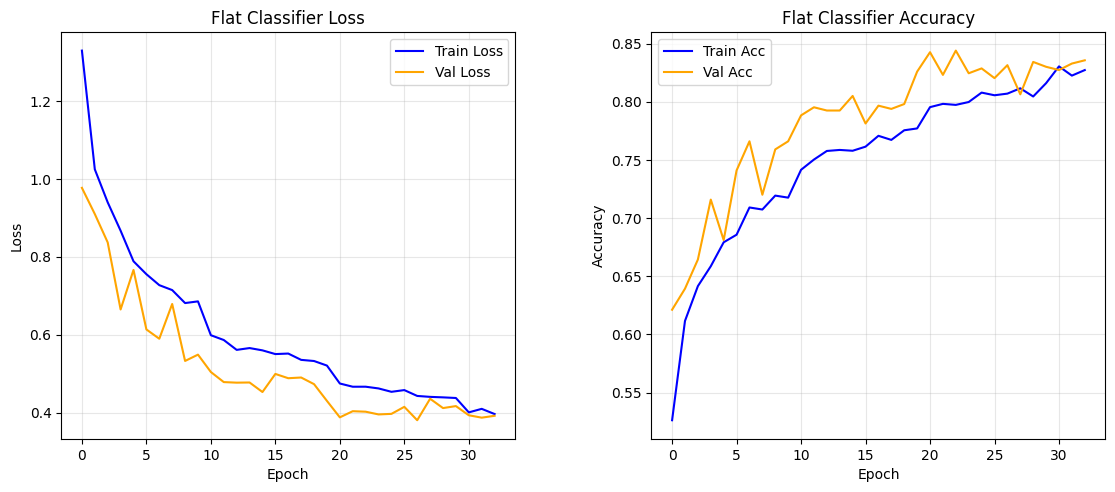

Figure saved to: /home/luca/HierarchicalMIC/models/flat-classifiers/densenet121_3d/baseline_training_densenet121_3d.png


In [7]:
save_dir = os.path.join(PATHS['models'], 'flat-classifiers', architecture)
os.makedirs(save_dir, exist_ok=True)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].plot(history['train_loss'], label='Train Loss', color='blue')
axes[0].plot(history['val_loss'], label='Val Loss', color='orange')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Flat Classifier Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(history['train_acc'], label='Train Acc', color='blue')
axes[1].plot(history['val_acc'], label='Val Acc', color='orange')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Flat Classifier Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.subplots_adjust(wspace=200)
plt.tight_layout(pad=1.0)

fig_path = os.path.join(save_dir, f'baseline_training_{architecture}.png')
plt.savefig(fig_path, dpi=150)
plt.show()
print(f"Figure saved to: {fig_path}")

## 6. Evaluation on Test Set

EVALUATING ON TEST SET


Evaluating: 100%|██████████| 115/115 [00:01<00:00, 72.48it/s]



Accuracy:  0.8158
F1-Score:  0.7981
AUC:       0.9916


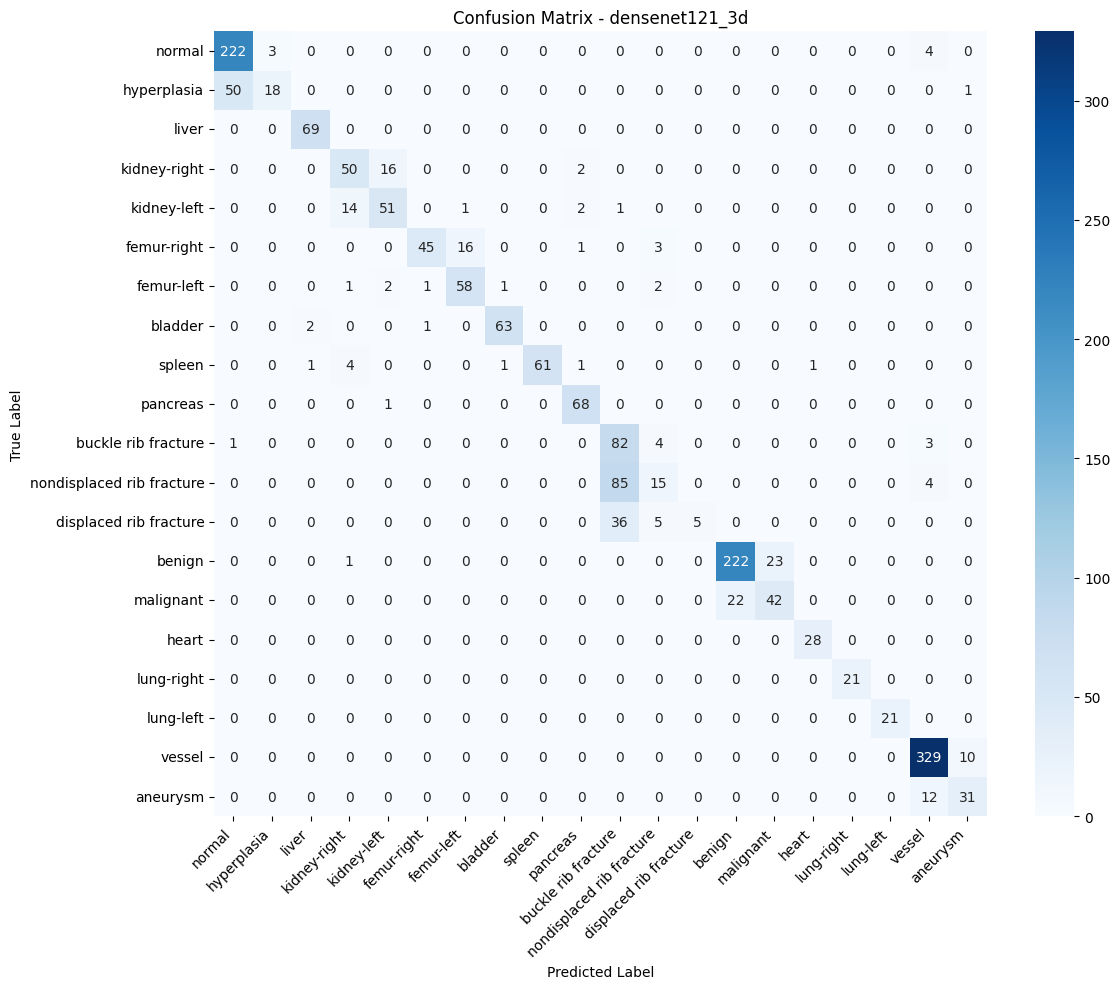

In [ ]:
print("="*80)
print("EVALUATING ON TEST SET")
print("="*80)

from utils.metrics import compute_comprehensive_metrics, save_metrics_json
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import json

# Create output directory
output_dir = f"{PATHS['models']}/flat-classifiers/{MODEL_CONFIG['architecture']}"
os.makedirs(output_dir, exist_ok=True)

# 1. Run Evaluation
model.eval()
all_preds = []
all_labels = []
all_probs = []

with torch.no_grad():
    for batch in tqdm(flat_test_loader, desc="Evaluating"):
        # Handle varying tuple sizes from dataloader
        if len(batch) == 3:
            imgs, _, labels = batch # Expecting (img, coarse, global_fine)
        else:
            imgs, labels = batch[:2]
            
        imgs = imgs.to(DEVICE, dtype=torch.float32)
        if imgs.max() > 1:
            imgs = imgs / 255.0
        
        labels = labels.long().to(DEVICE)
        
        outputs = model(imgs)
        probs = torch.softmax(outputs, dim=1)
        preds = outputs.argmax(1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.append(probs.cpu().numpy())

y_true = np.array(all_labels)
y_pred = np.array(all_preds)
y_probs = np.concatenate(all_probs, axis=0)

# Get class names
class_names = [f"Class_{i}" for i in range(dataset_info['num_fine_classes'])]
if 'global_idx_to_name' in dataset_info:
    class_names = [dataset_info['global_idx_to_name'][i]['name'] for i in range(dataset_info['num_fine_classes'])]

# Save predictions for results notebook
predictions_path = f"{output_dir}/predictions.json"
with open(predictions_path, 'w') as f:
    json.dump({
        'y_true': y_true.tolist(),
        'y_pred': y_pred.tolist(),
        'y_probs': y_probs.tolist(),
        'labels': class_names
    }, f)
print(f"Predictions saved to: {predictions_path}")

# 2. Compute Metrics
metrics = compute_comprehensive_metrics(
    y_true, y_pred, y_probs, class_names=class_names
)

print(f"Accuracy:  {metrics['accuracy']:.4f}")
print(f"F1-Score:  {metrics['f1_weighted']:.4f}")
if 'auc_weighted' in metrics:
    print(f"AUC:       {metrics['auc_weighted']:.4f}")

# 3. Plot Confusion Matrix
plt.figure(figsize=(12, 10))
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title(f'Confusion Matrix - {MODEL_CONFIG["architecture"]}')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig(f"{output_dir}/confusion_matrix.png", dpi=150)
plt.show()



## Save Model and Information for Flat-Classifier

In [9]:
# 4. Save Standardized Metrics JSON
full_metrics = {
    "model_type": "flat",
    "architecture": MODEL_CONFIG['architecture'],
    "metrics": metrics,
    "training_history": {
        "best_val_acc": float(history['best_val_acc']) if 'best_val_acc' in history else 0.0,
        "final_train_loss": float(history['train_loss'][-1]) if history['train_loss'] else None
    }
}

json_path = f"{output_dir}/metrics.json"
save_metrics_json(full_metrics, json_path)
# 5. Save Model State
torch.save(model.state_dict(), f"{output_dir}/model.pth")
print(f"Model saved to: {output_dir}/model.pth")


Metrics saved to: /home/luca/HierarchicalMIC/models/flat-classifiers/densenet121_3d/metrics.json
Model saved to: /home/luca/HierarchicalMIC/models/flat-classifiers/densenet121_3d/model.pth
